Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Label encoders saved at: /content/drive/MyDrive/le_bmi_category.pkl, /content/drive/MyDrive/le_meal_type.pkl
Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4555 - loss: 1.5636 - val_accuracy: 0.5386 - val_loss: 1.2680
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5533 - loss: 1.2559 - val_accuracy: 0.5386 - val_loss: 1.2776
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5504 - loss: 1.2540 - val_accuracy: 0.5386 - val_loss: 1.2531
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5501 - loss: 1.2426 - val_accuracy: 0.5386 - val_loss: 1.2782
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5619 - loss: 1.2211 - val_accuracy: 0.5386 - val_loss: 1.2457
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5583 - loss: 1.2057 - val_accuracy: 0.5386 - val_loss: 1

Model saved at: /content/drive/MyDrive/saved_diet_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5650 - loss: 1.1596
Model accuracy: 0.57
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


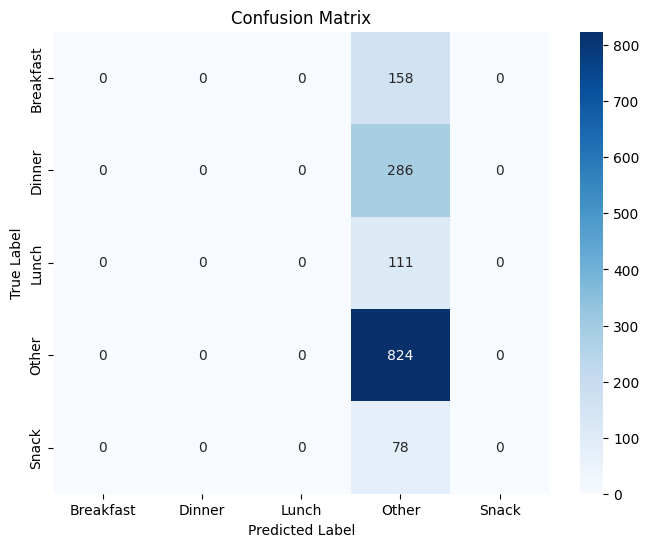

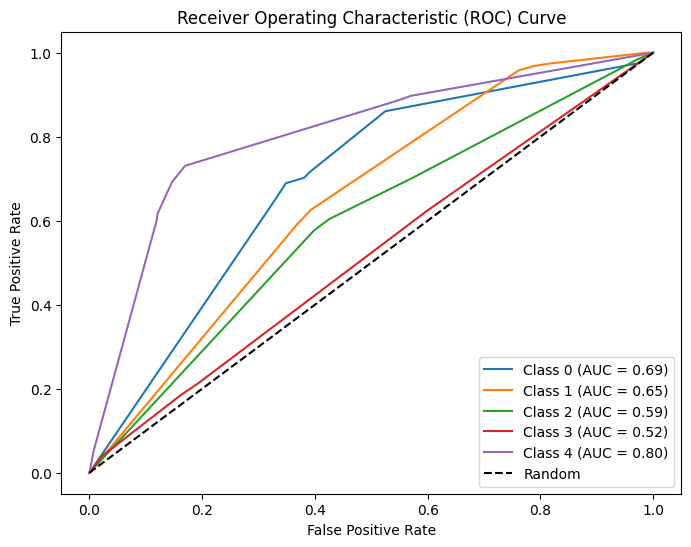

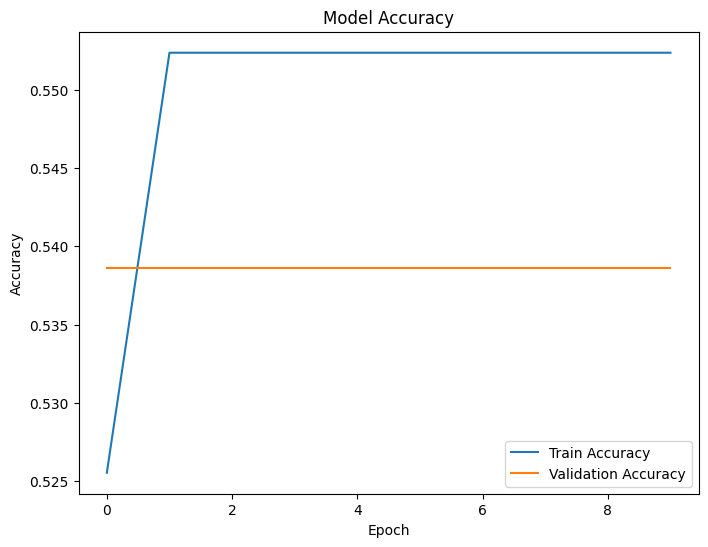

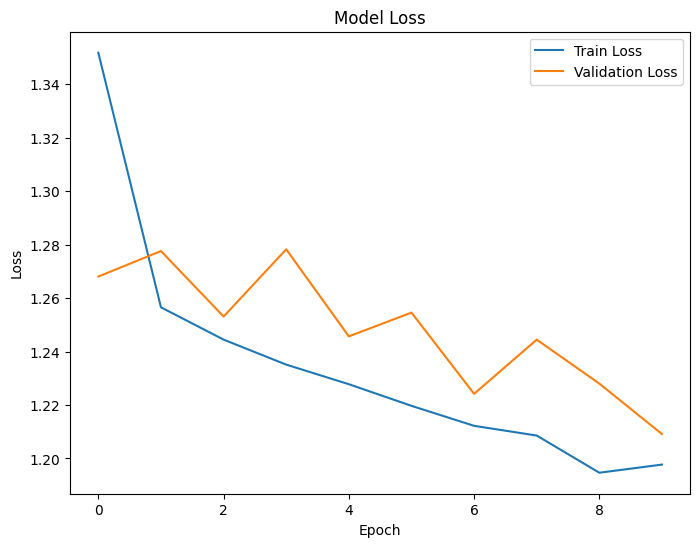

Accuracy plot saved at: /content/drive/MyDrive/accuracy_plot.png
Loss plot saved at: /content/drive/MyDrive/loss_plot.png
ROC curve saved at: /content/drive/MyDrive/roc_curve.png
Confusion matrix saved at: /content/drive/MyDrive/confusion_matrix.png


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
import joblib
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define paths for saving model, encoders, and images
model_save_path = '/content/drive/MyDrive/saved_diet_model.h5'
bmi_encoder_path = '/content/drive/MyDrive/le_bmi_category.pkl'
meal_type_encoder_path = '/content/drive/MyDrive/le_meal_type.pkl'

accuracy_plot_path = '/content/drive/MyDrive/accuracy_plot.png'
loss_plot_path = '/content/drive/MyDrive/loss_plot.png'
roc_curve_path = '/content/drive/MyDrive/roc_curve.png'
confusion_matrix_path = '/content/drive/MyDrive/confusion_matrix.png'

# Load the dataset from Google Drive
file_path = '/content/data/diet_dataset.csv'
df = pd.read_csv(file_path)

# Re-encode the BMI Category and Meal Type columns
le_bmi_category = LabelEncoder()
le_meal_type = LabelEncoder()
df['BMI_Category'] = le_bmi_category.fit_transform(df['BMI Category'])
df['Meal_Type'] = le_meal_type.fit_transform(df['Meal Type'])

# Save LabelEncoders to pickle files
joblib.dump(le_bmi_category, bmi_encoder_path)
joblib.dump(le_meal_type, meal_type_encoder_path)
print(f"Label encoders saved at: {bmi_encoder_path}, {meal_type_encoder_path}")

# Select features and target
X = df[['BMI', 'BMI_Category']]
y = df['Meal_Type']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(le_meal_type.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Save the trained model
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Model accuracy: {accuracy:.2f}")

# Predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot and save confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_meal_type.classes_, yticklabels=le_meal_type.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(confusion_matrix_path)
plt.show()

# ROC Curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(le_meal_type.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot and save ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(le_meal_type.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig(roc_curve_path)
plt.show()

# Accuracy and Loss Plot

# Plot and save accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(accuracy_plot_path)
plt.show()

# Plot and save loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig(loss_plot_path)
plt.show()

print(f"Accuracy plot saved at: {accuracy_plot_path}")
print(f"Loss plot saved at: {loss_plot_path}")
print(f"ROC curve saved at: {roc_curve_path}")
print(f"Confusion matrix saved at: {confusion_matrix_path}")
